# Using *Moves* data to see whether you're a rainy couch potato

This notebook uses your GPS tracks from *Moves* to find out how much you walked each day and where. Your geo location is then used to identify the local weather (temperature & precipitation) on that day through the *Dark Sky* API to see whether the local weather influences how much you walk. 

To get started we just need to set three settings below:

`DARKSKY_KEY` is your own API key for Dark Sky. You can [create one for free on their website](https://darksky.net/dev). Dark Sky allows you to make 1,000 calls per day for free. This notebook makes at worst 1 call for each day that is in your `DATARANGE`. So the 1,000 calls can get you ~ 2 1/2 years of local weather data. Once you have made an account you can enter you `DARKSKY_KEY` in the cell below. 

The `DATARANGE_START` and `DATARANGE_END` give the boundaries for which your analysis should be run (in `YYYY-MM-DD` format). Choose the values so that you have some *Moves* data between those boundaries and also that you're not requesting too much data from *Dark Sky* (or pay for requesting more data from *dark sky*, after the first 1,000 calls each day of weather data will be USD 0.0001)

In [ ]:
DARKSKY_KEY = 'ENTER_HERE' 
DATARANGE_START = "2016-06-01"
DATARANGE_END = "2018-05-08"

Let's load our dependencies for getting & analysing the *Moves* data

In [1]:
import os
import json
import requests
from datetime import datetime
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns


In [2]:
def longest_daily_location(daily_segments):
    """
    takes a daily segment log of Moves and returns the lat/long for the location where most time was spent
    """
    places_of_day = []
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            places_of_day.append([place_location,duration])
    places_of_day.sort(key=lambda tup: tup[-1],reverse=True)
    return places_of_day[0][0]

def weather_for_location_day(location, date):
    """
    take a location as returned by longest_daily_location 
    and a date of YYYYMMDD to get the weather:
    1. temperature high
    2. temperature low
    3. percipitation amount
    4. percipitation type
    """
    date = '{}-{}-{}T12:00:00'.format(
    date[:4],
    date[4:6],
    date[6:8])
    
    url = 'https://api.darksky.net/forecast/{}/{},{},{}?units=si'.format(DARKSKY_KEY,
    location['lat'],
    location['lon'],
    date
)
    response = requests.get(url)
    return response.json()

In [3]:
response = requests.get("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token={}".format(os.environ.get('OH_ACCESS_TOKEN')))
user = json.loads(response.content)

In [4]:
for dset in user['data']:
    if dset['source'] == 'direct-sharing-138':
        moves_data_raw = requests.get(dset['download_url']).content
        moves_data = json.loads(moves_data_raw)

In [6]:
weather_variables = ['precipType','precipIntensity','temperatureHigh','temperatureLow','precipIntensityMax','precipAccumulation']

moves_processed_data = defaultdict(list)

for datapoint in moves_data:
    if datapoint['segments'] != None:
        has_places = False
        for i in datapoint['segments']:
            if i['type'] == 'place':
                    has_places = True
        if datapoint['summary'] != None and has_places and datetime.strptime(datapoint['date'],"%Y%m%d") > datetime.strptime(DATARANGE_START,"%Y-%m-%d"):
            moves_processed_data['date'].append(datapoint['date'])
            for activity in datapoint['summary']:
                if activity['activity'] == 'walking':
                    moves_processed_data['steps'].append(activity['steps'])
                    moves_processed_data['distance'].append(activity['distance'])
            location = longest_daily_location(datapoint['segments'])
            moves_processed_data['lat'].append(location['lat'])
            moves_processed_data['lon'].append(location['lon'])
            weather = weather_for_location_day(location,datapoint['date'])
            for variable in weather_variables:
                if variable in weather['daily']['data'][0].keys():
                    moves_processed_data[variable].append(weather['daily']['data'][0][variable])
                else:
                    moves_processed_data[variable].append(0)
            if datetime.strptime(datapoint['date'],"%Y%m%d") > datetime.strptime(DATARANGE_END,"%Y-%m-%d"):
                break

In [7]:
moves_dataframe = pd.DataFrame(data={
    'date': moves_processed_data['date'],
    'steps': moves_processed_data['steps'],
    'distance': moves_processed_data['distance'],
    'latitude': moves_processed_data['lat'],
    'longitude': moves_processed_data['lon'],
    'precipType': moves_processed_data['precipType'],
    'precipIntensity': moves_processed_data['precipIntensity'],
    'precipIntensityMax': moves_processed_data['precipIntensityMax'],
    'precipAccumulation': moves_processed_data['precipAccumulation'],
    'temperatureHigh': moves_processed_data['temperatureHigh'],
    'temperatureLow': moves_processed_data['temperatureLow']
})

In [8]:
def get_year(instr):
    return instr[:4]

moves_dataframe['year'] = moves_dataframe.date.apply(get_year)

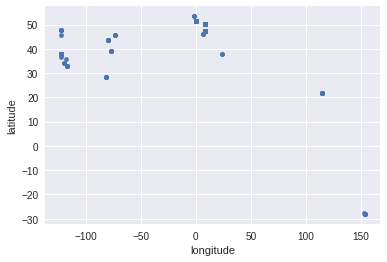

In [9]:
moves_dataframe.plot.scatter('longitude','latitude')

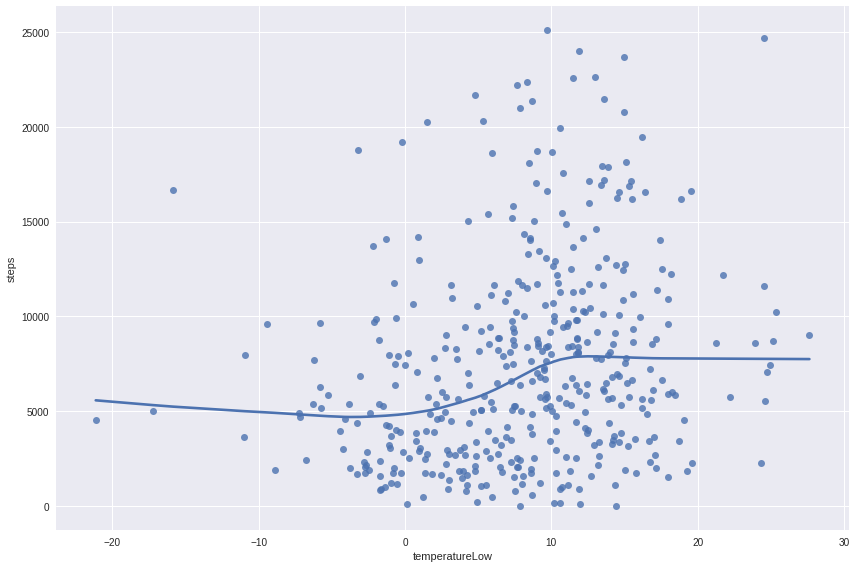

In [20]:
sns.lmplot(x="temperatureLow", y="steps", data=moves_dataframe,lowess=True,size=8,aspect=1.5)

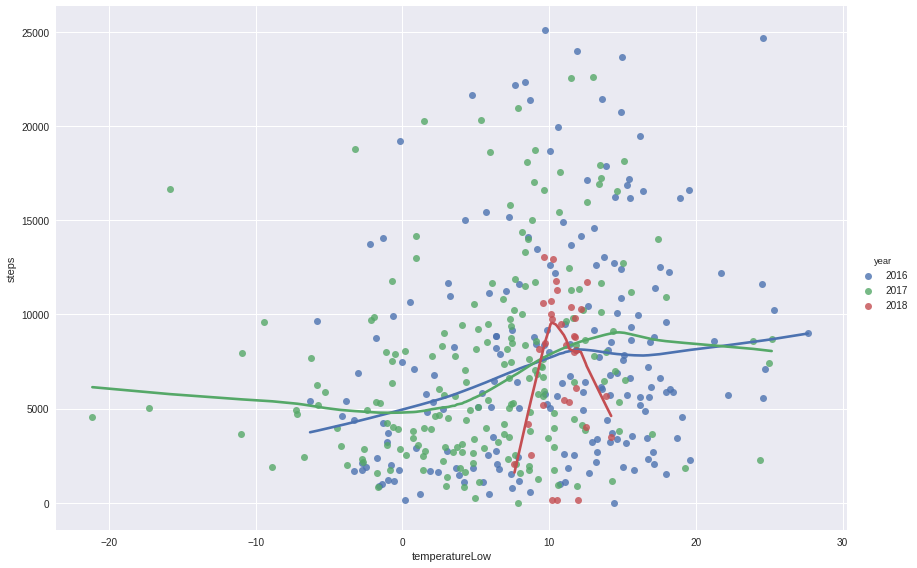

In [10]:
sns.lmplot(x="temperatureLow", y="steps", data=moves_dataframe,lowess=True,hue='year',size=8,aspect=1.5)

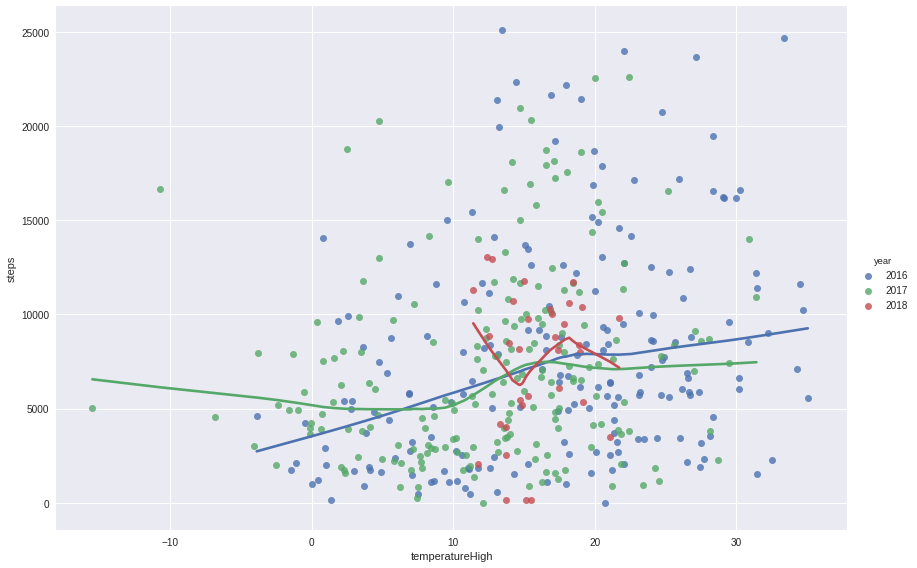

In [11]:
sns.lmplot(x="temperatureHigh", y="steps", data=moves_dataframe,lowess=True,hue='year',size=8,aspect=1.5)

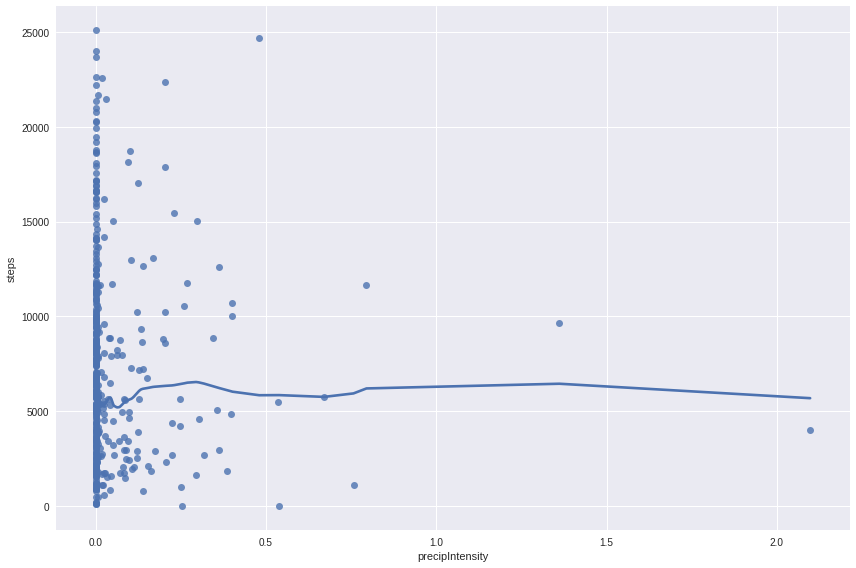

In [19]:
sns.lmplot(x="precipIntensity", y="steps", data=moves_dataframe,size=8,aspect=1.5,lowess=True)

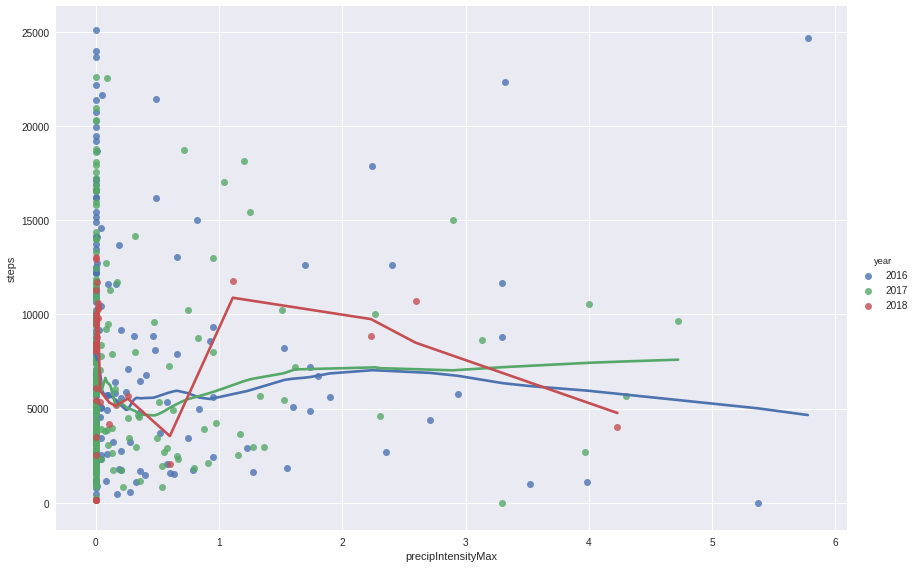

In [13]:
sns.lmplot(x="precipIntensityMax", y="steps", data=moves_dataframe,lowess=True,hue='year',size=8,aspect=1.5)

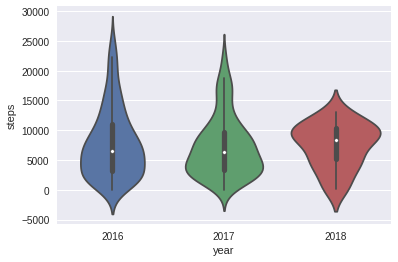

In [14]:
sns.violinplot(x='year',y='steps',data=moves_dataframe)

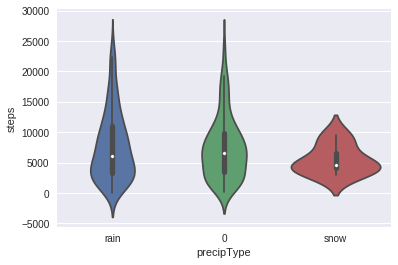

In [15]:
sns.violinplot(x='precipType',y='steps',data=moves_dataframe)

In [16]:
moves_dataframe[moves_dataframe['precipType'] == 'snow']

,date,distance,latitude,longitude,precipAccumulation,precipIntensity,precipIntensityMax,precipType,steps,temperatureHigh,temperatureLow,year
186,20161222,3486.0,50.060944,8.818717,2.202,0.1219,1.2294,snow,2919,0.96,0.93,2016
196,20170101,7241.0,50.114025,8.753432,0.102,0.0051,0.1346,snow,7922,-1.30,-0.49,2017
197,20170102,5701.0,50.114025,8.753432,0.102,0.0127,0.1803,snow,5375,1.48,-1.77,2017
200,20170105,8399.0,50.060944,8.818717,0.401,0.0229,0.4750,snow,9615,0.38,-9.46,2017
203,20170108,4879.0,50.114025,8.753432,0.147,0.0076,0.0457,snow,3915,0.65,-0.32,2017
205,20170110,4132.0,50.060944,8.818717,4.691,0.2464,0.9728,snow,4232,-0.08,-1.06,2017
263,20170310,5390.0,45.513387,-73.571229,0.996,0.0229,0.3505,snow,4546,-6.81,-21.13,2017
